# Overview

This example shows how to extract a time series of images from Earth Engine, annotate them, and save them as a video.

# Initialize Earth Engine

We start by importing the [Earth Engine Python API](https://pypi.org/project/earthengine-api/) module.

In [1]:
import ee

The following command initializes the Earth Engine Python API.

In [2]:
ee.Initialize()

If the cell produces output that displays an error about needing to authenticate, open up the notebook entitled `01 - Setup auth credentials` and follow the instructions.

# Define Helper Functions

In [3]:
def GetTileLayerUrl(ee_image_object):
    map_id = ee.Image(ee_image_object).getMapId()
    tile_url_template = "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
    return tile_url_template.format(**map_id)

# Building an image collection

In [4]:
import datetime
import ipywidgets as widgets
import ipyleaflet  # an interactive mapping "widget"

## Define the Image Collection to work with

In [5]:
vis_params = {
    'bands': ['HV'],
    'min':-20,
    'max':0,
}

## Define User Interface Elements

In [6]:
roi_dimension = widgets.IntSlider(
    value=1e4,
    min=1e2,
    max=2e4,
    description='ROI Size (m):',
    continuous_update=False,
)

In [7]:
# Define the map.
map1 = ipyleaflet.Map(
    center=(81.736, -45.912),
    zoom=8,
    layout={'height':'300px'},
)
map1.add_control(ipyleaflet.LayersControl())

# Define and add a Marker pin to the map.
center_marker = ipyleaflet.Marker(
    name='ROI Selection Marker',
    location=map1.center
)
map1 += center_marker

mosaic_layer_group = ipyleaflet.LayerGroup(layers=(), name='Mosaic Layer')
map1 += mosaic_layer_group

roi_layer_group = ipyleaflet.LayerGroup(layers=(), name='ROI Layer')
map1 += roi_layer_group

In [8]:
start_datepicker = widgets.DatePicker(
    description='Start Date',
    disabled=False,
    value=datetime.datetime(2017, 8, 1)
)
end_datepicker = widgets.DatePicker(
    description='End Date',
    disabled=False,
    value=datetime.datetime(2017, 8, 10)
)

In [9]:
out = widgets.Output()

## Display the UI Elements

In [10]:
# Layout the UI elements.
panel = widgets.VBox([
    map1,
    start_datepicker,
    end_datepicker,
    roi_dimension,
    out
])

out.clear_output()
display(panel)

## Define interactions

In [11]:
# Define helper functions to swap the coordinate ordering.
def swap_coordinate_xy_for_location(coord):
    return (coord[1],coord[0])

def swap_coordinate_xy_for_list(coord_list):
    return [swap_coordinate_xy_for_location(coord) for coord in coord_list]  

def update_roi_layer(map_reference):    
    coord_list_xy = get_roi_polygon()['coordinates'][0]
    coord_list_yx = swap_coordinate_xy_for_list(coord_list_xy)
    
    roi_layer = ipyleaflet.Polygon(
        name='TEST update ROI Polygon',
        locations=coord_list_yx,
        weight=3,
        color='#F00',
        opacity=0.8,
        fill_opacity=0.1,
        fill_color='#F00'
    )
    roi_layer_group.clear_layers()
    roi_layer_group.add_layer(roi_layer)

In [12]:
def get_roi_polygon():
    center_marker_xy = swap_coordinate_xy_for_location(center_marker.location)
    centroid = ee.Geometry.Point(center_marker_xy)
    buffered = centroid.buffer(roi_dimension.value).bounds()
    return buffered.getInfo() 

In [13]:
def get_image_collection():

    # Get filter values from the UI widgets.
    roi = get_roi_polygon()
    start_date = ee.Date(start_datepicker.value.isoformat())
    end_date = ee.Date(end_datepicker.value.isoformat())

    collection = (
        base_collection
          .filterDate(start_date, end_date)
          .filterBounds(roi)
    )
    return collection

In [14]:
base_collection = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
      .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
      .select(['HV'])
)

In [15]:
def update_mosaic_layer(map_reference):
    
    out.clear_output()
    with out:
        print('Total images = {0}'.format(get_image_collection().size().getInfo()))
    
    mosaic_tilelayer = ipyleaflet.TileLayer(
        url=GetTileLayerUrl(
            get_image_collection().mosaic().visualize(**vis_params)
        ),
        attribution='Map tiles by <a href="http://earthengine.google.com/">Earth Engine</a>.'
    )
    mosaic_layer_group.clear_layers()
    mosaic_layer_group.add_layer(mosaic_tilelayer)

In [16]:
# Define the actions performed when the marker moves.
def center_marker_on_move(change):
    update_roi_layer(map1)
    update_mosaic_layer(map1)
center_marker.unobserve_all()
center_marker.observe(center_marker_on_move, names='location')

In [17]:
# Define the actions performed when the ROI size is changed.
def roi_dimension_on_change(change):
    update_roi_layer(map1)
    update_mosaic_layer(map1)
roi_dimension.unobserve_all()
roi_dimension.observe(roi_dimension_on_change, names='value')

Initialize the overlay layers.

In [18]:
update_roi_layer(map1)
update_mosaic_layer(map1)

# Testing out a series

This section will demonstrate outputing an image time series for the specified location, time interval, and image collection.

In [19]:
collection = get_image_collection()
print(collection.size().getInfo())

15


In [20]:
MAX_ELEMENTS=100
images = collection.toList(MAX_ELEMENTS).getInfo()

In [21]:
[img['id'] for img in images]

['COPERNICUS/S1_GRD/S1B_EW_GRDH_1SDH_20170801T115853_20170801T115953_006746_00BDEC_CD24',
 'COPERNICUS/S1_GRD/S1B_EW_GRDH_1SDH_20170803T114230_20170803T114330_006775_00BEC0_0FB5',
 'COPERNICUS/S1_GRD/S1B_EW_GRDH_1SDH_20170805T112608_20170805T112708_006804_00BF90_D5E8',
 'COPERNICUS/S1_GRD/S1B_EW_GRDH_1SDH_20170806T120705_20170806T120805_006819_00C005_F47A',
 'COPERNICUS/S1_GRD/S1B_EW_GRDH_1SDH_20170808T115042_20170808T115142_006848_00C0DF_58E7',
 'COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170802T110130_20170802T110213_006760_00BE54_8FE2',
 'COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170803T181419_20170803T181524_006779_00BEDA_4205',
 'COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170804T104513_20170804T104613_006789_00BF1F_FF61',
 'COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170805T175757_20170805T175901_006808_00BFA7_A5A1',
 'COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170806T102844_20170806T102919_006818_00BFFD_F715',
 'COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170806T183851_20170806T183955_006823_00C024_2873',
 'COPERNIC

In [22]:
import os
output_directory = 'output'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

COPERNICUS/S1_GRD/S1B_EW_GRDH_1SDH_20170801T115853_20170801T115953_006746_00BDEC_CD24


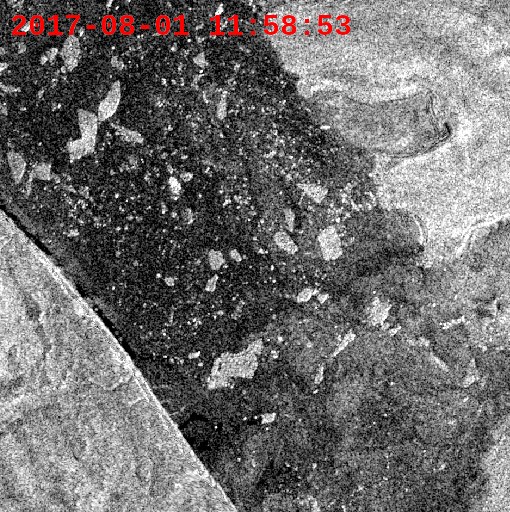

In [25]:
import datetime
from IPython.display import Image
import imageio
import pprint
import PIL.Image
import PIL.ImageDraw
import PIL.ImageFont
import requests
import numpy

pp = pprint.PrettyPrinter(indent=4)

image_no = 0

for img in images[0:1]:
    image_no += 1
    id = img['id']
    print(id)

    image_time_ms = img['properties']['system:time_start']
    start_time = datetime.datetime.fromtimestamp(image_time_ms/1000.0)

    sample = ee.Image(id)
    url = sample.getThumbUrl({
        'bands': 'HH',
        'min':-20,
        'max':0,
        'region':get_roi_polygon()
    })

    # Create a base image, from the Earth Engine Thumbnail URL.
    base_ee = PIL.Image.open(requests.get(url, stream=True).raw).convert('RGBA')

    # Create a background image.
    background = PIL.Image.new('RGBA', base_ee.size, (12,12,12,255))

    # Burn the EE data onto the backgound.
    base = PIL.Image.alpha_composite(background, base_ee)

    # make a blank image for the text, initialized to transparent text color
    txt = PIL.Image.new('RGBA', base_ee.size, (255,255,255,0))

    # Get a font.
    # Additional fonts available on this server can be found by running the following in a terminal:
    # find / -name *.ttf
    fnt = PIL.ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', 30)

    # Get a drawing context.
    d = PIL.ImageDraw.Draw(txt)
    # Draw text. For date formatting codes see:
    # https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    date_string = '{:%Y-%m-%d %H:%M:%S}'.format(start_time)
    d.text((10,10), date_string, font=fnt, fill=(255,0,0,255))
    # Composite the image and text annotation.
    out_image = PIL.Image.alpha_composite(base, txt)

    outfile = '{0}/img{1:03d}.png'.format(output_directory, image_no)
    out_image.save(outfile, format='PNG')

    display(out_image)

## Create an animated GIF.

In [ ]:
import glob

gif_images = []
filenames = sorted(glob.glob('output/img???.png'))
for filename in filenames:
    gif_images.append(imageio.imread(filename))
imageio.mimsave('output/movie.gif', gif_images, 'GIF', duration=0.5)

## Create an MPEG video.

In [ ]:
%%bash  
ffmpeg -r 1 \
    -i output/img%03d.png \
    -vcodec mpeg4 \
    -y output/out.mp4